# What is the True Normal Human Body Temperature? 

#### Background

The mean normal body temperature was held to be 37$^{\circ}$C or 98.6$^{\circ}$F for more than 120 years since it was first conceptualized and reported by Carl Wunderlich in a famous 1868 book. But, is this value statistically correct?

<h3>Exercises</h3>

<p>In this exercise, you will analyze a dataset of human body temperatures and employ the concepts of hypothesis testing, confidence intervals, and statistical significance.</p>

<p>Answer the following questions <b>in this notebook below and submit to your Github account</b>.</p> 

<ol>
<li>  Is the distribution of body temperatures normal? 
    <ul>
    <li> Although this is not a requirement for the Central Limit Theorem to hold (read the introduction on Wikipedia's page about the CLT carefully: https://en.wikipedia.org/wiki/Central_limit_theorem), it gives us some peace of mind that the population may also be normally distributed if we assume that this sample is representative of the population.
    <li> Think about the way you're going to check for the normality of the distribution. Graphical methods are usually used first, but there are also other ways: https://en.wikipedia.org/wiki/Normality_test
    </ul>
<li>  Is the sample size large? Are the observations independent?
    <ul>
    <li> Remember that this is a condition for the Central Limit Theorem, and hence the statistical tests we are using, to apply.
    </ul>
<li>  Is the true population mean really 98.6 degrees F?
    <ul>
    <li> First, try a bootstrap hypothesis test.
    <li> Now, let's try frequentist statistical testing. Would you use a one-sample or two-sample test? Why?
    <li> In this situation, is it appropriate to use the $t$ or $z$ statistic? 
    <li> Now try using the other test. How is the result be different? Why?
    </ul>
<li>  Draw a small sample of size 10 from the data and repeat both frequentist tests. 
    <ul>
    <li> Which one is the correct one to use? 
    <li> What do you notice? What does this tell you about the difference in application of the $t$ and $z$ statistic?
    </ul>
<li>  At what temperature should we consider someone's temperature to be "abnormal"?
    <ul>
    <li> As in the previous example, try calculating everything using the boostrap approach, as well as the frequentist approach.
    <li> Start by computing the margin of error and confidence interval. When calculating the confidence interval, keep in mind that you should use the appropriate formula for one draw, and not N draws.
    </ul>
<li>  Is there a significant difference between males and females in normal temperature?
    <ul>
    <li> What testing approach did you use and why?
    <li> Write a story with your conclusion in the context of the original problem.
    </ul>
</ol>

You can include written notes in notebook cells using Markdown: 
   - In the control panel at the top, choose Cell > Cell Type > Markdown
   - Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

#### Resources

+ Information and data sources: http://www.amstat.org/publications/jse/datasets/normtemp.txt, http://www.amstat.org/publications/jse/jse_data_archive.htm
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

****

In [33]:
import pandas as pd

df = pd.read_csv('data/human_body_temperature.csv')

In [34]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns

%matplotlib inline

from scipy import stats

from scipy.stats import norm

In [35]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Q1 Is the distribution of body temperatures normal?

In [36]:
# Your work here.

# First, we will inspect the data visually and then we will also run a statistcal test. 


### 1a Visual Inspection

Text(0, 0.5, 'Count')

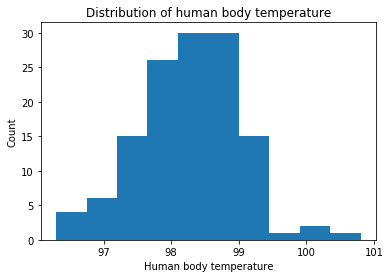

In [37]:
plt.hist(df['temperature'], bins = 10)
plt.title('Distribution of human body temperature')
plt.xlabel('Human body temperature')
plt.ylabel('Count')

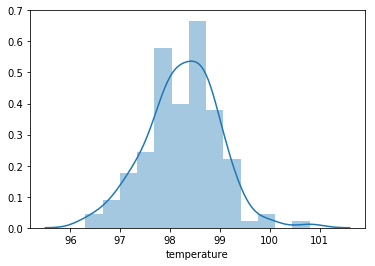

In [38]:
sns.distplot(df['temperature'])

### 1b Statistical Test

In [39]:
# Shapiro-Wilk Test
# Source: https://machinelearningmastery.com/a-gentle-introduction-to-normality-tests-in-python/
from scipy.stats import shapiro

# normality test
stat, p = shapiro(df['temperature'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
 print('Sample looks Gaussian (fail to reject H0)')
else:
 print('Sample does not look Gaussian (reject H0)')


Statistics=0.987, p=0.233
Sample looks Gaussian (fail to reject H0)


### 1c Conclusion

Based on visual and statistical test, we can conclude that the data is normally distributed. 

## Q2 Is the sample size large? Are the observations independent?

### 2a. Is the sample size large?

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130 entries, 0 to 129
Data columns (total 3 columns):
temperature    130 non-null float64
gender         130 non-null object
heart_rate     130 non-null float64
dtypes: float64(2), object(1)
memory usage: 3.1+ KB


Here the sample size is 130 which is higher than "30" which is regarded as threshold for large sample size. 

Source here: http://sphweb.bumc.bu.edu/otlt/mph-modules/bs/bs704_probability/BS704_Probability12.html 

So, yes, the sample size is large enough. 

### 2b. Are the observations independent?

Indepedence means that you don’t want one person appearing twice in two different groups as it could skew your results. So let's check if there are duplicate rows and if a person is apprearing multiple times!

In [41]:
data = df.groupby(['gender','temperature', 'heart_rate']).size() > 1
data.value_counts()

False    124
True       3
dtype: int64

So, it looks like out of 130 observations, only 3 pairs (total 6 observations) are duplicate. So it does look like that we can assume that the observations are independenet

### Q3. Is the true population mean really 98.6 degrees F?

#### 3a. Calculating statistics

In [47]:
#calculating statistics
sample_mean = np.mean(df.temperature)
sample_mean

98.24923076923078

In [48]:
sample_std = np.std(df.temperature)
sample_std

0.7303577789050377

In [49]:
test_mean = 98.6

#### 3b. bootstrapping

To perform bootstrap hypothesis test, I will resample 10,000x and then calculate 1) mean of resampled 10,000 samples 2) distribution of mean plotted with 95% confidence interval. 

Now our null hypothesis = 98.6 is the population mean temperature; so if 98.6 is outside the the interval in the resampled distribution then we reject the null hypothesis. 

In [50]:
def draw_bs_reps(data, func, size=1):
    """Draw bootstrap replicates."""
    def bootstrap_replicate_1d(data, func):
        return func(np.random.choice(data, size=len(data)))

    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data, func)

    return bs_replicates

In [52]:
temperatures = df.temperature

#resmample the sample 10,000 times and calculate the mean of all 10,000 samples

bs_samples = draw_bs_reps(temperatures, np.mean, 10000)
#calculate the mean of distribution of means
bs_mean = np.mean(bs_samples)
#calculate the standard deviation of distribution of means
bs_std = np.std(temperatures) / np.sqrt(len(temperatures))
percentiles = np.percentile(bs_samples, [2.5,97.5])
#calculate the 95% percentile
print('mean: ',bs_mean,'\nstandard deviation: ', bs_std, '\n95% confidence intervals: ', percentiles)

mean:  98.24894961538462 
standard deviation:  0.06405661469519336 
95% confidence intervals:  [98.12307692 98.37461538]


Since 98.6 is outside the confidence interval, we can reject the null hypothesis and conclude that, 98.6 is unlikely to be the population mean. 

#### 3c Z-statistic

Since n>30, we will use z-statistic instead of t. 

In [56]:
#calculate Z value
n=130
Z = ((sample_mean - test_mean) / (sample_std / np.sqrt(n)))
print(Z)

-5.475925202078116


1-sample test

In [57]:
#scipy
stats.ttest_1samp(df.temperature, test_mean)

Ttest_1sampResult(statistic=-5.4548232923645195, pvalue=2.4106320415561276e-07)

I reject the null hypothesis given the low pvalue, meaning that the actual population mean is likely different than 98.6 degrees

### Q4 Draw a small sample of size 10 from the data and repeat both frequentist tests.

In [65]:
sample_data_n10 = np.random.choice(temperatures, size=10)

In [67]:
n=10

mean = np.mean(sample_data_n10)
    
#calculate the standard deviation
std = np.std(sample_data_n10)
    
#calculate the SE standard mean error (standard deviation of the sampled means)
mean_sample_std = (std) / np.sqrt(n)

In [69]:
#Perform z-statistics
z_score = (98.6 - mean) / mean_sample_std
p_value = stats.norm.cdf(98.6, mean, mean_sample_std)

print(z_score)
print(p_value)

0.9651730079944421
0.8327709179585618


In [70]:
#Perform t-statistics
stats.ttest_1samp(sample_data_n10, 98.6)

Ttest_1sampResult(statistic=-0.9156435124135021, pvalue=0.38373147413081043)

since the sample size is less than 30, t statistic and z-statistic are different. That was not the case when n > 30 earlier

### Q5 At what temperature should we consider someone's temperature to be "abnormal"?

In [60]:
sample_std = np.std(df.temperature)
sample_std

0.7303577789050377

In [61]:
sample_mean = np.mean(df.temperature)
sample_mean

98.24923076923078

In [62]:
#let's compute a 95% confidence interval which is the normal range. 

In [63]:
# A 95% confidence interval would be +- 2 std from the mean
CI_upper = sample_mean + (sample_std * 2)
CI_lower = sample_mean - (sample_std * 2)

In [64]:
print('Upper Limit Confidence Interval ' + str(CI_upper))
print('Lower Limit Confidence Interval ' + str(CI_lower))

Upper Limit Confidence Interval 99.70994632704085
Lower Limit Confidence Interval 96.7885152114207


so, anything below 96.78 and above 99.7 should be considered abnormal. 

### Q6 Is there a significant difference between males and females in normal temperature?

let's use the 2-sample t test to deteremine if the two samples are same or not. 

Our null hypothesis = temperature mean of male & female sample is same

2-sample test

In [58]:
df_female = df[df['gender'] == 'F']
df_male = df[df['gender'] == 'M']
stats.ttest_ind(df_female['temperature'],df_male['temperature'])

Ttest_indResult(statistic=2.2854345381656103, pvalue=0.02393188312239561)

I reject the null hypothesis given the low pvalue. So that means that there is likely a significant difference between males and females in normal temperature

## Conclusion

1) Sample distribution of temperatures to be normally distributed and independent 

2) Based on statistical tests, Population mean is unlikely to be 98.6 

3) A normal range of body temperature is between 96.7 - 99.7

4) There is likely a significant differece in normal temperature between males & females 